In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%reload_ext lab_black

In [9]:
import logging
import string
import sys
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from src.figure_utilities import (
    PAGE_HEIGHT,
    ONE_COLUMN,
    TWO_COLUMN,
    save_figure,
    set_figure_defaults,
)
from src.parameters import STATE_COLORS, TRANSITION_TO_CATEGORY, STATE_ORDER, PROBABILITY_THRESHOLD

set_figure_defaults()

In [34]:
from src.analysis import load_all_replay_info


replay_info = load_all_replay_info(
    n_unique_spiking=2,
    data_type="clusterless",
    dim="1D",
    probability_threshold=PROBABILITY_THRESHOLD,
    speed_threshold=4,
    exclude_interneuron_spikes=False,
)

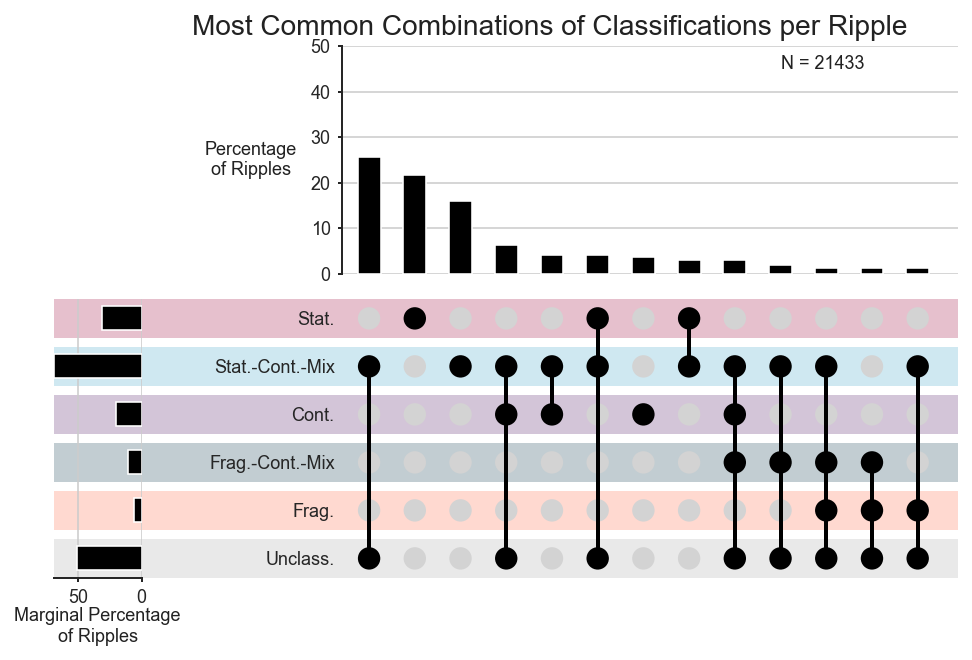

In [58]:
from src.visualization import plot_upset_classification

classified_replay_info = replay_info.loc[
    replay_info.is_classified & (replay_info.duration_classified > 0.015)
]

ax_dict, upset = plot_upset_classification(
    classified_replay_info, intersection_frac_threshold=0.01,
)

save_figure(os.path.join("Figure5", "figure5_upset"))

In [36]:
n_states = classified_replay_info.loc[:, STATE_ORDER[:-1]].sum(axis=1)

print(
    f"Number of single dynamic: {(n_states == 1).sum()} / {len(classified_replay_info)} or {(n_states == 1).mean() * 100:0.0f}%\n"
    f"Number of multiple dynamics: {(n_states > 1).sum()} / {len(classified_replay_info)} or {(n_states > 1).mean() * 100:0.0f}%\n"
    f"Number of >2 dynamics: {(n_states > 2).sum()} / {len(classified_replay_info)} or {(n_states > 2).mean() * 100:0.0f}%\n"
)

Number of single dynamic: 14989 / 21433 or 70%
Number of multiple dynamics: 6444 / 21433 or 30%
Number of >2 dynamics: 1319 / 21433 or 6%



In [37]:
num = (classified_replay_info["Hover-Continuous-Mix"] & (n_states == 1)).sum()
denom = len(classified_replay_info)

print(
    f"Number of Only Stationary-Continuous-Mix: {num} / {denom} or {num / denom * 100:0.0f}%\n"
)

Number of Only Stationary-Continuous-Mix: 8944 / 21433 or 42%



In [38]:
is_scm = classified_replay_info["Hover-Continuous-Mix"] & (n_states == 1)
scm_duration = classified_replay_info.loc[is_scm].duration.median() * 1000
scm_distance_from_animal = classified_replay_info.loc[
    is_scm
].replay_distance_from_actual_position.median()

print(f"Only Stationary-Continuous-Mix duration: {scm_duration:0.0f} ms")
print(
    f"Only Stationary-Continuous-Mix distance from animal: {scm_distance_from_animal:0.0f} cm"
)

Only Stationary-Continuous-Mix duration: 73 ms
Only Stationary-Continuous-Mix distance from animal: 52 cm


In [39]:
is_continuous = classified_replay_info["Continuous"]
continuous_duration = classified_replay_info.loc[is_continuous].duration.median() * 1000
continuous_distance_from_animal = classified_replay_info.loc[
    is_continuous
].replay_distance_from_actual_position.median()

print(f"continuous duration: {continuous_duration:0.0f} ms")
print(f"continuous distance from animal: {continuous_distance_from_animal:0.0f} cm")

continuous duration: 94 ms
continuous distance from animal: 43 cm


In [73]:
num = (classified_replay_info["Hover"] & (n_states == 1)).sum()
denom = len(classified_replay_info)

print(f"Number of Only Stationary: {num} / {denom} or {num / denom * 100:0.0f}%\n")

Number of Only Stationary: 4858 / 21433 or 23%



In [41]:
num = (classified_replay_info["Fragmented"] & (n_states == 1)).sum()
denom = len(classified_replay_info)

print(f"Number of Only Fragmented: {num} / {denom} or {num / denom * 100:0.0f}%\n")

Number of Only Fragmented: 235 / 21433 or 1%



In [42]:
has_short_duration_jump = (
    (
        classified_replay_info["Fragmented"]
        | classified_replay_info["Fragmented-Continuous-Mix"]
    )
    & (
        classified_replay_info["Hover"]
        | classified_replay_info["Hover-Continuous-Mix"]
        | classified_replay_info["Continuous"]
    )
    & (
        (classified_replay_info["Fragmented_duration"] < 0.010)
        | (classified_replay_info["Fragmented-Continuous-Mix_duration"] < 0.010)
    )
)
num = has_short_duration_jump.sum()
denom = len(classified_replay_info)

print(f"Number of short duration jump: {num} / {denom} or {num / denom * 100:0.0f}%\n")

Number of short duration jump: 2190 / 21433 or 10%



In [43]:
has_spatially_coherent_and_incoherent = (
    classified_replay_info["Fragmented"]
    | classified_replay_info["Fragmented-Continuous-Mix"]
) & (
    classified_replay_info["Hover"]
    | classified_replay_info["Hover-Continuous-Mix"]
    | classified_replay_info["Continuous"]
)
num = has_spatially_coherent_and_incoherent.sum()
denom = len(classified_replay_info)

print(
    f"Number of spatially coherent and incoherent: {num} / {denom} or {num / denom * 100:0.0f}%\n"
)

Number of spatially coherent and incoherent: 2281 / 21433 or 11%



In [44]:
has_no_spatially_coherent_and_incoherent = (
    classified_replay_info["Fragmented"]
    | classified_replay_info["Fragmented-Continuous-Mix"]
) & ~(
    classified_replay_info["Hover"]
    | classified_replay_info["Hover-Continuous-Mix"]
    | classified_replay_info["Continuous"]
)

num = has_no_spatially_coherent_and_incoherent.sum()
denom = len(classified_replay_info)

print(
    f"Number of not spatially coherent and incoherent: {num} / {denom} or {num / denom * 100:0.0f}%\n"
)

Number of not spatially coherent and incoherent: 607 / 21433 or 3%



In [45]:
import re
import ast


def convert_object_to_array(fixed_string):
    pattern = r"""# Match (mandatory) whitespace between...
                  (?<=\]) # ] and
                  \s+
                  (?= \[) # [, or
                  |
                  (?<=[^\[\]\s]) 
                  \s+
                  (?= [^\[\]\s]) # two non-bracket non-whitespace characters
               """

    # Replace such whitespace with a comma
    fixed_string = re.sub(pattern, ",", fixed_string, flags=re.VERBOSE)

    return np.array(ast.literal_eval(fixed_string))


def get_norm_linear_position(replay_info):
    non_local_stationary = replay_info.loc[
        replay_info.Hover_replay_distance_from_actual_position > 30
    ]
    norm_linear_position = []
    for ripple_id, df in non_local_stationary.iterrows():
        try:
            temp = (
                convert_object_to_array(df.Hover_replay_linear_position)
                / df.left_well_position
            )
            for pos in temp:
                norm_linear_position.append(pos)
        except TypeError:
            norm_linear_position.append(
                df.Hover_replay_linear_position / df.left_well_position
            )
    return np.asarray(norm_linear_position)

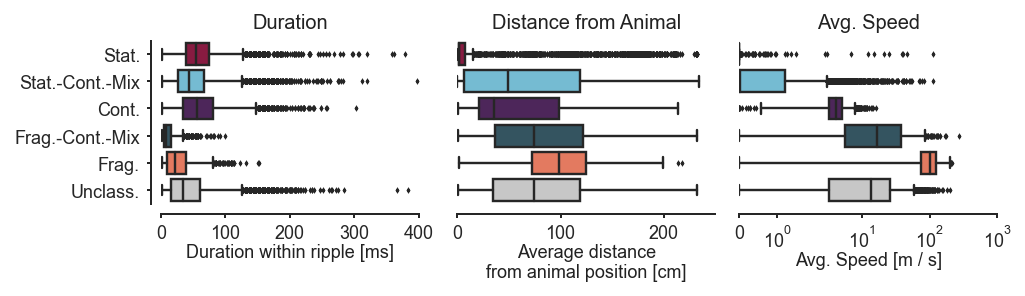

In [66]:
from src.visualization import (
    plot_replay_distance_from_actual_position,
    plot_category_duration,
    plot_linear_position_markers,
    plot_population_rate,
    _plot_category,
)
import glob

from src.parameters import STATE_ORDER
from src.visualization import SHORT_STATE_NAMES


saturation, fliersize = 0.7, 1

fig, axes = plt.subplots(
    nrows=1, ncols=3, figsize=(TWO_COLUMN, PAGE_HEIGHT / 5), constrained_layout=True
)

# Duration of Dynamic
plot_category_duration(
    classified_replay_info,
    kind="box",
    ax=axes[0],
    fliersize=fliersize,
    saturation=saturation,
)
axes[0].set_title("Duration", fontsize=10)
axes[0].set_xlim((0, 400))
sns.despine(ax=axes[0], offset=5)

# Distance from Animal
plot_replay_distance_from_actual_position(
    classified_replay_info,
    kind="box",
    ax=axes[1],
    fliersize=fliersize,
    saturation=saturation,
)
axes[1].set_title("Distance from Animal", fontsize=10)
sns.despine(ax=axes[1], offset=5)
axes[1].set_xlim((0, 250))
axes[1].set_yticks([])
axes[1].spines["left"].set_visible(False)


# Replay Speed
coherent_speeds = [
    "Hover_replay_speed",
    "Hover-Continuous-Mix_replay_speed",
    "Continuous_replay_speed",
]
incoherent_speeds = [
    "Fragmented-Continuous-Mix_replay_speed",
    "Fragmented_replay_speed",
    "Unclassified_replay_speed",
]

all_speeds = [*coherent_speeds, *incoherent_speeds]

d = classified_replay_info.filter(all_speeds, axis=1).rename(
    columns=lambda c: SHORT_STATE_NAMES[c.split("_")[0]]
)

durations = [f"{state}_duration" for state in STATE_ORDER]
mask = classified_replay_info.filter(durations) <= 0.020
mask[mask == 1] = np.nan
mask[mask == 0] = 1.0

d = d * mask.values

sns.boxplot(
    data=d / 100,
    orient="horizontal",
    palette=STATE_COLORS,
    fliersize=fliersize,
    saturation=saturation,
    ax=axes[2],
)
axes[2].set_xscale("symlog")
axes[2].set_xlim((0, 1e3))
axes[2].set_xlabel("Avg. Speed [m / s]")
axes[2].set_title("Avg. Speed", fontsize=10)
axes[2].set_yticks([])
sns.despine(ax=axes[2], offset=5)
axes[2].spines["left"].set_visible(False)
save_figure(os.path.join("Figure5", "figure5_dynamics_summary1"))

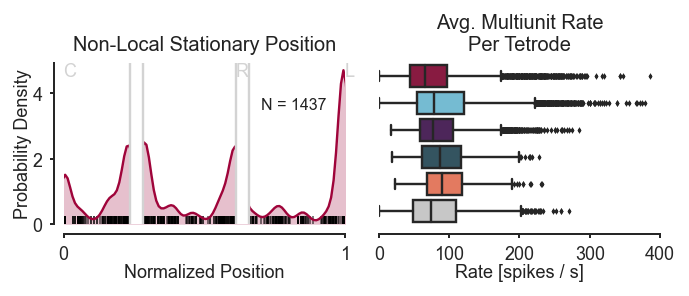

In [76]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(TWO_COLUMN * 2 / 3, PAGE_HEIGHT / 5),
    constrained_layout=True,
)

# Non-Local Stationary Position
norm_non_local_hover = get_norm_linear_position(classified_replay_info)

sns.distplot(
    norm_non_local_hover,
    kde_kws=dict(
        bw=0.020,
        clip=(0, 1),
        shade=True,
        facecolor=STATE_COLORS["Hover"],
        legend=False,
    ),
    rug_kws=dict(color="black", alpha=0.5),
    kde=True,
    rug=True,
    hist=False,
    color=STATE_COLORS["Hover"],
    ax=axes[0],
)
axes[0].set_xticks([0.0, 1.0])
axes[0].set_xlabel("Normalized Position")
axes[0].set_ylabel("Probability Density")
plot_linear_position_markers(
    classified_replay_info,
    is_normalized=True,
    jitter=0.00,
    zorder=101,
    alpha=1,
    ax=axes[0],
    linestyle="-",
    fontsize=9,
)

sns.despine(ax=axes[0], offset=5)
axes[0].set_xlim((0, 1))
axes[0].set_title("Non-Local Stationary Position", fontsize=10)
n_non_local = (
    (classified_replay_info.Hover_replay_distance_from_actual_position > 30)
).sum()
axes[0].text(0.70, 3.5, f"N = {n_non_local}", zorder=100, fontsize=8)

# Population firing rate
rates = [f"{state}_population_rate" for state in STATE_ORDER]
d = classified_replay_info.filter(rates, axis=1).rename(
    columns=lambda c: SHORT_STATE_NAMES[c.split("_")[0]]
)

durations = [f"{state}_duration" for state in STATE_ORDER]
mask = classified_replay_info.filter(durations) <= 0.020
mask[mask == 1] = np.nan
mask[mask == 0] = 1.0

d = d * mask.values

sns.boxplot(
    data=d,
    orient="horizontal",
    palette=STATE_COLORS,
    fliersize=fliersize,
    saturation=saturation,
    ax=axes[1],
)

axes[1].set_xlim((0, 400))
axes[1].set_xlabel("Rate [spikes / s]")
axes[1].set_title("Avg. Multiunit Rate\nPer Tetrode", fontsize=10)
sns.despine(ax=axes[1], offset=5)
axes[1].set_yticks([])
axes[1].spines["left"].set_visible(False)
save_figure(os.path.join("Figure5", "figure5_dynamics_summary2"))

In [47]:
from scipy.stats import ranksums

ranksums(
    classified_replay_info.Hover_population_rate,
    classified_replay_info.Continuous_population_rate,
)

RanksumsResult(statistic=55.13990504692148, pvalue=0.0)

In [48]:
np.nanmedian(classified_replay_info.Hover_population_rate), np.nanmedian(
    classified_replay_info.Continuous_population_rate
)

(65.02525252525253, 76.47058823529412)

In [75]:
num = ((classified_replay_info.Hover_replay_distance_from_actual_position > 30)).sum()
denom = len(classified_replay_info)

print(f"Number of Non-Local Stationary: {num} / {denom} or {num / denom * 100:0.0f}%\n")

Number of Non-Local Stationary: 1437 / 21433 or 7%



In [77]:
num = (
    (classified_replay_info.Hover_replay_distance_from_actual_position > 30)
    & (n_states == 1)
).sum()
denom = ((classified_replay_info.Hover_replay_distance_from_actual_position > 30)).sum()

print(f"Number of Non-Local Stationary: {num} / {denom} or {num / denom * 100:0.0f}%\n")

Number of Non-Local Stationary: 664 / 1437 or 46%



In [51]:
f"{classified_replay_info.Hover_replay_distance_from_actual_position.max():0.0f}"

'232'